In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from multipy.fwer import bonferroni
from itertools import combinations
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
google_url = 'https://docs.google.com/spreadsheets/d/1gv8I7HlBQX1Fr1wRSKS7VTFr1b5Wlmfd9Yup4VjmwpI/edit#gid=1849363064'
google_csv = google_url.replace('/edit#gid=', '/export?format=csv&gid=')

In [3]:
payments = pd.read_csv(google_csv)

В гугл-таблице оказалась одиночная ячейка с формулой, поэтому при загрузке датафрейма добавились лишние безымянные колонки. Оставим только колонки с данными.

In [4]:
payments = payments[['user_id','Amount','Type','Payment Dt','Week #','Month','Quarter','Year']]

In [5]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10711 entries, 0 to 10710
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     10711 non-null  object
 1   Amount      10711 non-null  object
 2   Type        10711 non-null  object
 3   Payment Dt  10711 non-null  object
 4   Week #      10711 non-null  int64 
 5   Month       10711 non-null  int64 
 6   Quarter     10711 non-null  object
 7   Year        10711 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 669.6+ KB


In [6]:
payments.head()

,user_id,Amount,Type,Payment Dt,Week #,Month,Quarter,Year
0,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,3/24/2021 5:53:06,13,3,Q1,2021
1,ff734fd5-1d24-4715-bc90-21c8bb53d9ee,0,yearly_fee_2,4/10/2021 0:05:05,15,4,Q2,2021
2,08ee994c-0986-5bd5-bd0a-dee747cd28c3,89.49,deposit_fee,4/19/2021 21:05:21,17,4,Q2,2021
3,0baa3728-7fd6-5077-8d91-6bbedd907007,36.07,deposit_fee,4/24/2021 1:57:52,17,4,Q2,2021
4,5da37a68-a74e-5ec9-b2d4-250d568ec730,45.62,deposit_fee,5/15/2021 4:26:21,20,5,Q2,2021


Приведем колонки ```Amount``` и ```Payment Dt``` к нужным типам данных (float и timestamp). Обнаружилась строка с аномальным значением ```Amount``` **"-"**, будем считать, что платежа не было и исправим на 0.

In [7]:
payments.loc[payments.Amount == '-','Amount'] = 0

In [8]:
payments.Amount = payments.Amount.astype(float)

In [9]:
payments['Payment Dt'] = pd.to_datetime(payments['Payment Dt'])

In [10]:
payments.dtypes

user_id               object
Amount               float64
Type                  object
Payment Dt    datetime64[ns]
Week #                 int64
Month                  int64
Quarter               object
Year                   int64
dtype: object

In [11]:
# Загрузим данные по событиям
events = pd.read_pickle('./events_pickled')

In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22623922 entries, 0 to 578
Data columns (total 50 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   app                        int64  
 1   device_id                  object 
 2   user_id                    object 
 3   client_event_time          object 
 4   event_id                   int64  
 5   session_id                 int64  
 6   event_type                 object 
 7   amplitude_event_type       float64
 8   version_name               float64
 9   platform                   object 
 10  os_name                    object 
 11  os_version                 object 
 12  device_brand               object 
 13  device_manufacturer        object 
 14  device_model               object 
 15  device_family              object 
 16  device_type                object 
 17  device_carrier             object 
 18  location_lat               float64
 19  location_lng               float64
 20  ip_ad

In [14]:
# Приведем колонки с датами к типу datetime
events[['client_event_time', 'user_creation_time']] = events[['client_event_time', 'user_creation_time']].apply(pd.to_datetime)

In [15]:
# Приведем номера версий приложения к строковому типу
events.version_name = events.version_name.astype(str)

In [16]:
# Для дат регистрации и событий выделим отдельные колонки с месяцем и годом
events['reg_month_year'] = events['user_creation_time'].dt.to_period('M')
events['event_month_year'] = events['client_event_time'].dt.to_period('M')

Посчитаем количество новых пользователей по месяцам. Поскольку не у всех пользователей есть ```user_id```, будем использовать ```device_id``` как идентификатор.

In [17]:
new_users_platform = (
    events.groupby(['reg_month_year', 'platform'],as_index=False)
    .device_id.count().rename(columns={'device_id':'users'})
)

In [18]:
new_users_platform

,reg_month_year,platform,users
0,2020-06,iOS,760
1,2020-07,Android,1018
2,2020-07,iOS,2026
3,2020-08,iOS,13211
4,2020-09,Android,141730
5,2020-09,iOS,154906
6,2020-10,Android,137806
7,2020-10,iOS,80014
8,2020-11,Android,204005
9,2020-11,iOS,123533


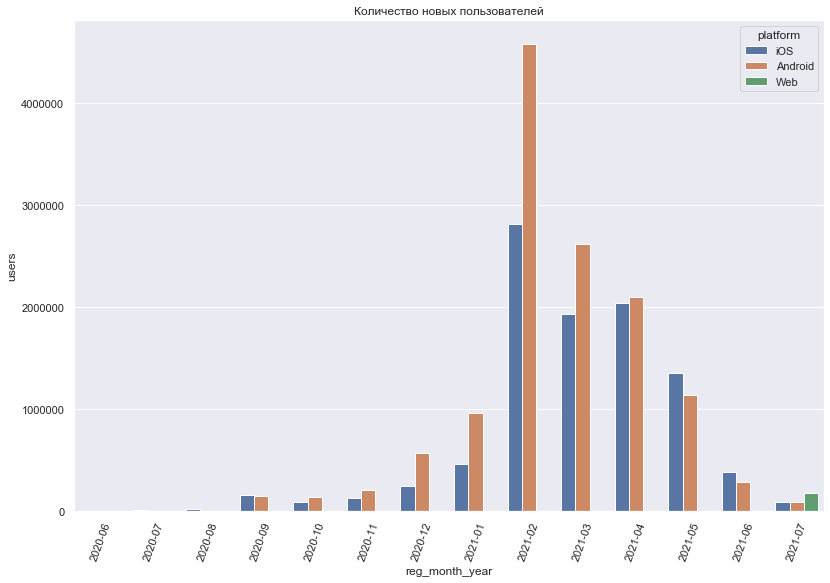

In [19]:
sns.barplot(x='reg_month_year', y='users', data=new_users_platform, hue='platform').set(title='Количество новых пользователей')
plt.xticks(rotation=70)
plt.tight_layout()

In [20]:
# распределение версий приложения
events.groupby('version_name').device_id.nunique()

version_name
0.0         9
10.0        2
11.0        2
12.0       14
13.0        7
14.0       61
16.0      163
17.0     7538
18.0     7919
19.0    12866
20.0     5969
20.1        7
21.0    23137
22.0    14984
23.0    37505
23.1        4
24.0    15492
24.1       37
25.0       11
26.0     9224
27.0     1757
28.0    10602
7.0         6
8.0         8
9.0         4
nan     32266
Name: device_id, dtype: int64

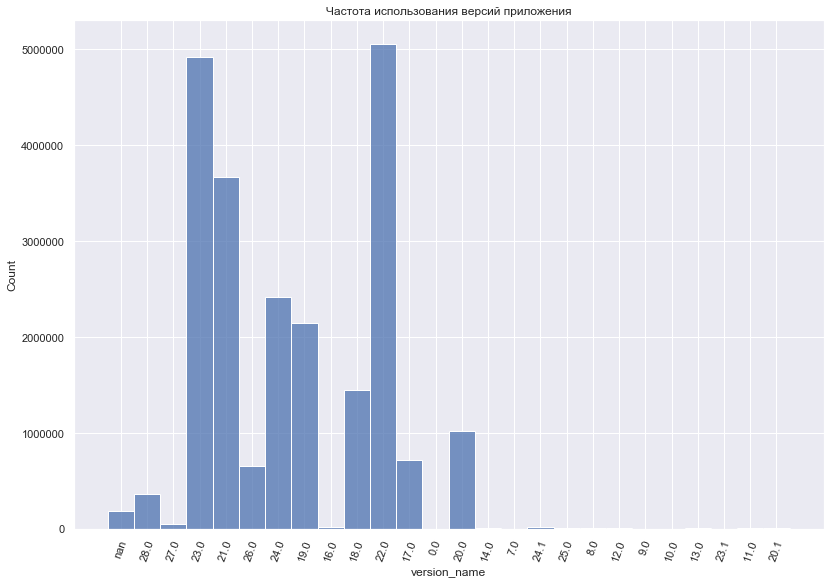

In [21]:
sns.histplot(events.version_name).set(title='Частота использования версий приложения')
plt.xticks(rotation=70)
plt.tight_layout()

In [22]:
# Объединим часть данных из датасета платежей и датасета событий 
clients = pd.merge(payments, events[['user_id','version_name', 'platform', 'user_creation_time']], how='left', on='user_id')

In [23]:
clients['period'] = clients['Payment Dt'].dt.to_period('M')

In [24]:
clients = clients.query("Amount != 0")

In [25]:
clients = clients.drop(clients[clients.platform.isna()].index)

Оставим только те версии, которые были прибыльнее и/или популярнее ```28.0```

In [26]:
clients.groupby('version_name', as_index=False).user_id.count().sort_values(by='user_id', ascending=False)

,version_name,user_id
7,23.0,5788
5,21.0,4493
8,24.0,2114
3,19.0,2056
6,22.0,1610
1,17.0,1491
2,18.0,1141
12,28.0,610
10,26.0,541
13,nan,293


In [27]:
clients.groupby('version_name', as_index=False).Amount.sum().sort_values(by='Amount', ascending=False)

,version_name,Amount
7,23.0,966132.3030
5,21.0,791043.2905
3,19.0,393485.3665
1,17.0,340797.2510
8,24.0,320270.5000
6,22.0,296576.8700
2,18.0,292643.8075
10,26.0,53019.2160
12,28.0,50143.8655
13,nan,46882.3900


In [28]:
versions = ['17.0', '18.0', '19.0', '21.0', '22.0', '23.0', '24.0', '26.0', '28.0']

In [29]:
clients = clients[clients.version_name.isin(versions)]

In [30]:
clients.head()

,user_id,Amount,Type,Payment Dt,Week #,Month,Quarter,Year,version_name,platform,user_creation_time,period
0,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,2021-03-24 05:53:06,13,3,Q1,2021,26.0,Android,2020-09-18 09:48:56.853,2021-03
1,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,2021-03-24 05:53:06,13,3,Q1,2021,24.0,Android,2020-09-18 09:48:56.853,2021-03
2,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,2021-03-24 05:53:06,13,3,Q1,2021,22.0,Android,2020-09-18 09:48:56.853,2021-03
3,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,2021-03-24 05:53:06,13,3,Q1,2021,22.0,Android,2020-09-18 09:48:56.853,2021-03
5,08ee994c-0986-5bd5-bd0a-dee747cd28c3,89.49,deposit_fee,2021-04-19 21:05:21,17,4,Q2,2021,21.0,Android,2021-03-02 23:17:40.571,2021-04


**Посмотрим на конверсию по платформе и версиям приложения:**

In [31]:
conversion_by_platform = (
    clients.groupby(['period', 'platform'], as_index=False)
    .user_id.count().rename(columns={'user_id':'clients'})
)

In [32]:
all_users_by_platform = (
    events.groupby(['event_month_year', 'platform'], as_index=False)
    .device_id.count().rename(columns={'device_id':'all_users', 'event_month_year':'period'})
)

In [33]:
conversion_by_platform = (
    pd.merge(conversion_by_platform, all_users_by_platform, how='left', on=['period', 'platform'])
)

In [34]:
conversion_by_platform = conversion_by_platform.dropna()

In [35]:
conversion_by_platform['conversion'] = (conversion_by_platform.clients / conversion_by_platform.all_users) * 100

In [36]:
conversion_by_platform.drop(index=[11, 12, 14], inplace=True)

In [37]:
conversion_by_platform

,period,platform,clients,all_users,conversion
13,2021-01,Android,6,1333.0,0.450113
15,2021-02,Android,170,1759947.0,0.009659
17,2021-02,iOS,1685,1120812.0,0.150337
18,2021-03,Android,784,4068306.0,0.019271
20,2021-03,iOS,1508,2020201.0,0.074646
21,2021-04,Android,2516,3599600.0,0.069897
23,2021-04,iOS,4615,2625607.0,0.175769
24,2021-05,Android,1788,2173643.0,0.082258
26,2021-05,iOS,3353,2371621.0,0.141380
27,2021-06,Android,645,827459.0,0.077949


[Text(0.5, 1.0, 'Конверсия по платформе')]

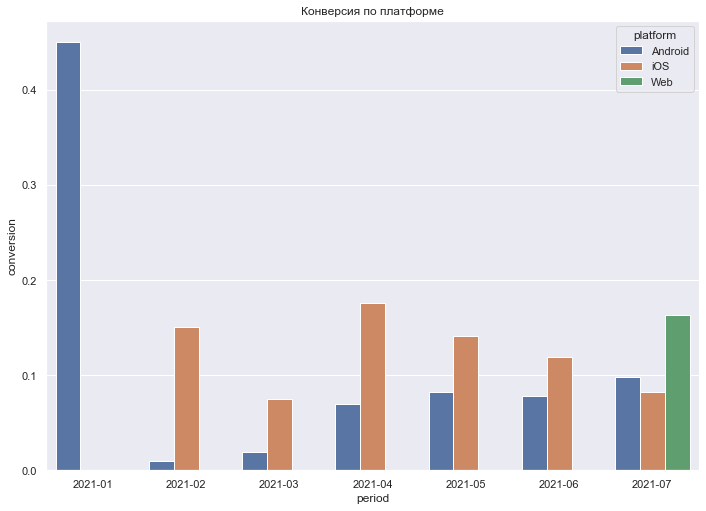

In [38]:
sns.barplot(x='period', y='conversion', data=conversion_by_platform, hue='platform').set(title='Конверсия по платформе')

In [39]:
conversion_by_ver = (
    clients.groupby(['period', 'version_name'], as_index=False)
    .user_id.count().rename(columns={'user_id':'clients'})
)

In [41]:
all_users_by_ver = (
    events.groupby(['event_month_year', 'version_name'], as_index=False)
    .device_id.count().rename(columns={'device_id':'all_users', 'event_month_year':'period'})
)

In [42]:
conversion_by_ver = pd.merge(conversion_by_ver, all_users_by_ver, how='left', on=['period', 'version_name'])

In [43]:
conversion_by_ver = conversion_by_ver.dropna()

In [44]:
conversion_by_ver.drop(conversion_by_ver[conversion_by_ver.clients > conversion_by_ver.all_users].index, inplace=True)

In [45]:
conversion_by_ver['conversion'] = conversion_by_ver.clients / conversion_by_ver.all_users * 100

In [46]:
conversion_by_ver.drop(index=[32, 38, 39, 40], inplace=True)

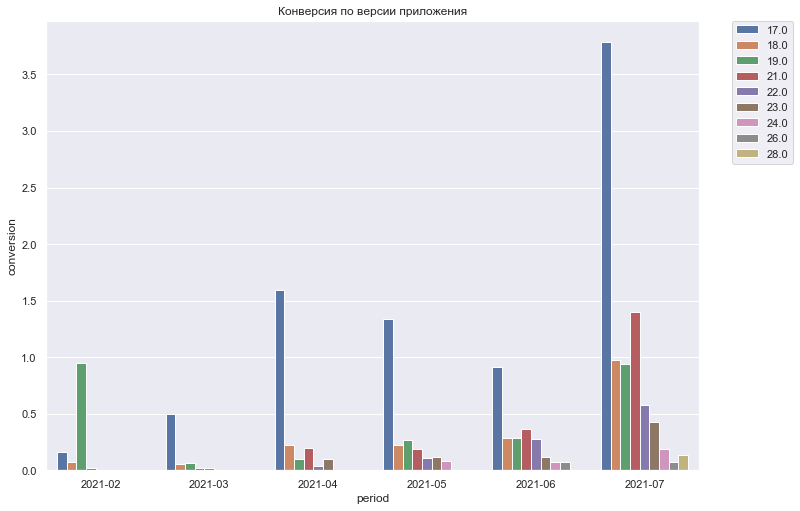

In [47]:
sns.barplot(x='period', y='conversion', data=conversion_by_ver, hue='version_name').set(title='Конверсия по версии приложения')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Посмотрим на среднее количество действий в приложении:**

In [48]:
clients['event_day'] = clients['Payment Dt'].dt.to_period('D')

In [49]:
events['event_day'] = events['client_event_time'].dt.to_period('D')

In [50]:
pay_days = list(clients.event_day.unique())

In [51]:
client_ids = list(clients.user_id.unique())

In [52]:
clients_log = events[(events.event_day.isin(pay_days)) & (events.user_id.isin(client_ids))]

In [53]:
clients_log = clients_log[['device_id', 'user_id', 'client_event_time', 'event_id', 'session_id', 'event_type', 'version_name', 'platform', 'event_month_year', 'event_day']]

In [54]:
event_num_by_plf = clients_log.groupby(['platform', 'user_id'], as_index=False).event_type.count()

In [55]:
event_num_by_plf.groupby('platform', as_index=False).event_type.mean().round(2).rename(columns={'event_type':'actions_average'})

,platform,actions_average
0,Android,2.02
1,Web,14.56
2,iOS,1.99


In [56]:
event_num_by_ver = clients_log.groupby(['version_name', 'user_id'], as_index=False).event_type.count()

In [57]:
event_num_by_ver.groupby('version_name', as_index=False).event_type.mean().round(2).rename(columns={'event_type':'actions_average'})

,version_name,actions_average
0,17.0,1.31
1,18.0,1.22
2,19.0,1.41
3,20.0,1.00
4,21.0,2.12
5,22.0,1.44
6,23.0,2.10
7,24.0,2.06
8,24.1,1.00
9,26.0,1.85


**Посмотрим на конверсионное окно:**

In [58]:
first_purchase = clients.groupby('user_id', as_index=False)['Payment Dt'].min().rename(columns={'Payment Dt':'first_purchase'})

In [59]:
clients = pd.merge(clients, first_purchase, on='user_id', how='left')

In [60]:
clients['conversion_window'] = (clients.first_purchase - clients.user_creation_time).dt.days

In [61]:
clients.query('conversion_window >= 0').groupby('platform', as_index=False).agg({'conversion_window':'mean'})

,platform,conversion_window
0,Android,12.755368
1,Web,7.631980
2,iOS,13.170074


[Text(0.5, 1.0, 'Конверсионное окно в днях по платформам')]

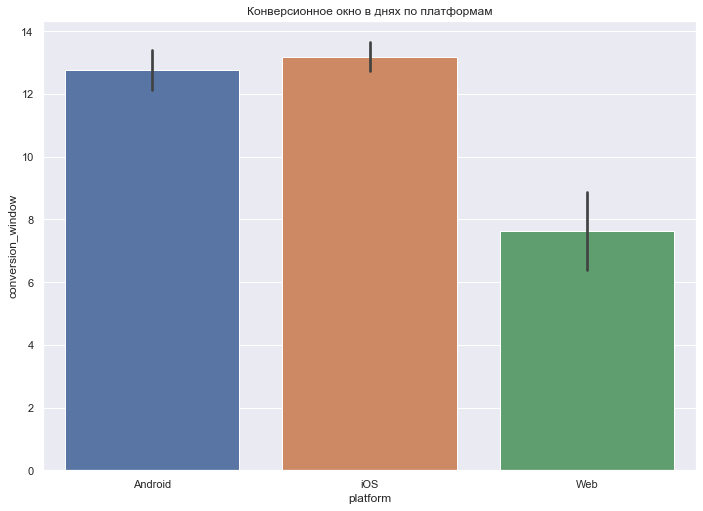

In [62]:
sns.barplot(y=clients.query('conversion_window >= 0').conversion_window, x=clients.platform).set(title='Конверсионное окно в днях по платформам')

In [63]:
clients.query('conversion_window >= 0').groupby('version_name', as_index=False).agg({'conversion_window':'mean'})

,version_name,conversion_window
0,17.0,7.762860
1,18.0,11.302503
2,19.0,10.923630
3,21.0,12.664275
4,22.0,11.349081
5,23.0,15.169746
6,24.0,12.246000
7,26.0,18.095238
8,28.0,14.523726


[Text(0.5, 1.0, 'Конверсионное окно в днях по версиям')]

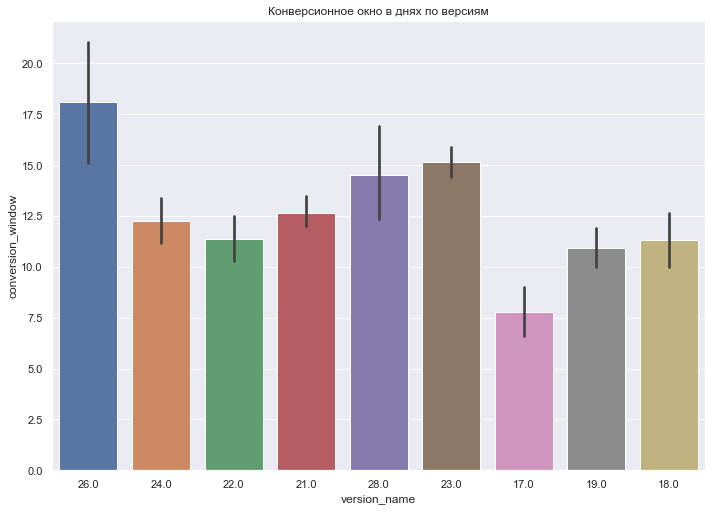

In [64]:
sns.barplot(y=clients.query('conversion_window >= 0').conversion_window, x=clients.version_name).set(title='Конверсионное окно в днях по версиям')

**Посмотрим на средний чек:**

In [65]:
clients['month_period'] = clients['period'].dt.to_timestamp()

In [66]:
clients.groupby(['platform', 'period'], as_index=False).Amount.mean()

,platform,period,Amount
0,Android,2020-09,62.510000
1,Android,2020-10,199.905000
2,Android,2020-11,104.256667
3,Android,2020-12,135.604737
4,Android,2021-01,66.350000
5,Android,2021-02,131.440471
6,Android,2021-03,145.781314
7,Android,2021-04,181.525774
8,Android,2021-05,165.393020
9,Android,2021-06,138.498992


In [67]:
clients.groupby(['version_name','period'], as_index=False).Amount.mean()

,version_name,period,Amount
0,17.0,2020-09,74.307273
1,17.0,2020-10,75.133750
2,17.0,2020-11,62.685455
3,17.0,2020-12,65.627714
4,17.0,2021-01,81.278723
...,...,...,...
94,28.0,2021-03,79.184333
95,28.0,2021-04,141.841821
96,28.0,2021-05,244.772381
97,28.0,2021-06,160.873846


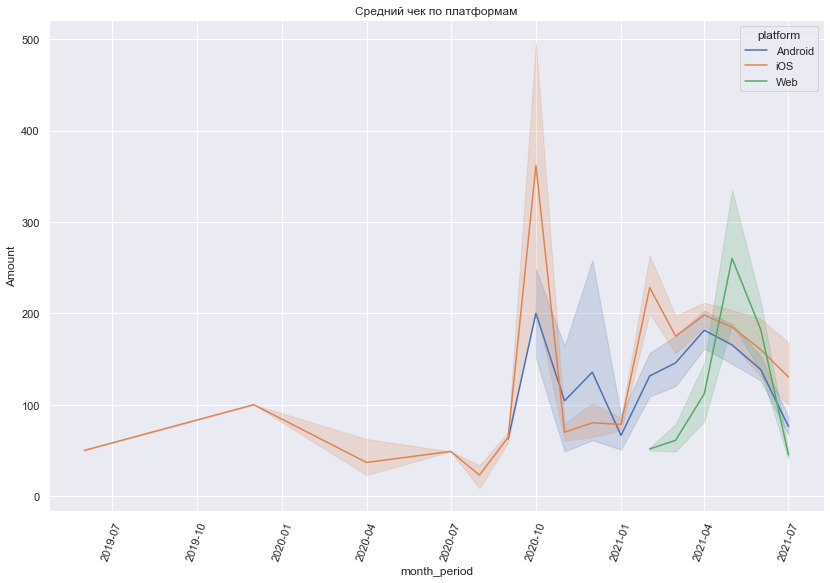

In [68]:
sns.lineplot(data=clients, x='month_period', y='Amount', hue='platform').set(title='Средний чек по платформам')
plt.xticks(rotation=70)
plt.tight_layout()

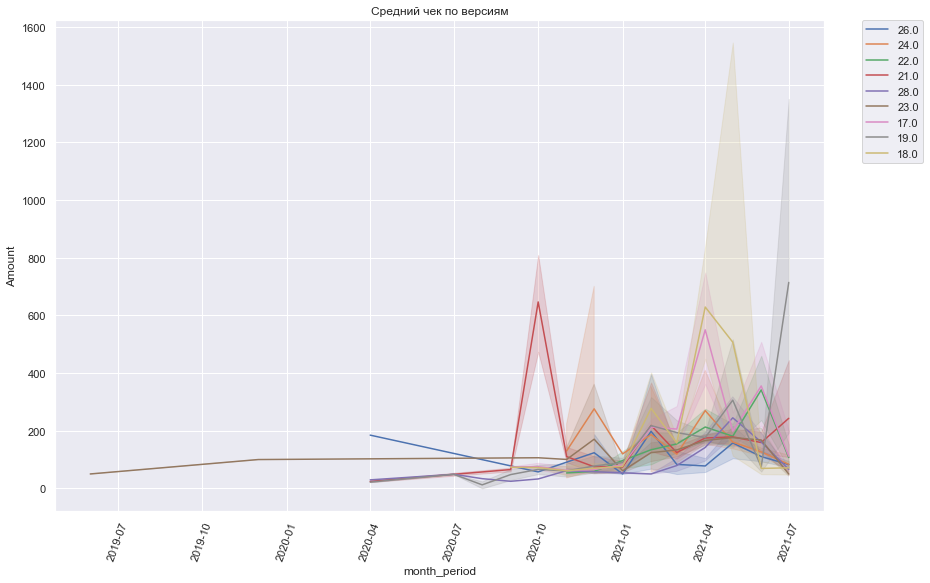

In [69]:
sns.lineplot(data=clients, x='month_period', y='Amount', hue='version_name').set(title='Средний чек по версиям')
plt.xticks(rotation=70)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


**Изучим структуру прибыли в динамике:**  
Будем считать новыми пользователями тех, кто зарегистрировался и совершил оплату в один и тот же месяц. 

In [70]:
clients['reg_period'] = clients.user_creation_time.dt.to_period('M')

In [71]:
clients['user_category'] = np.where(clients.reg_period == clients.period, 'new', 'old')

In [72]:
clients

,user_id,Amount,Type,Payment Dt,Week #,Month,Quarter,Year,version_name,platform,user_creation_time,period,event_day,first_purchase,conversion_window,month_period,reg_period,user_category
0,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,2021-03-24 05:53:06,13,3,Q1,2021,26.0,Android,2020-09-18 09:48:56.853,2021-03,2021-03-24,2020-12-11 03:58:06,83,2021-03-01,2020-09,old
1,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,2021-03-24 05:53:06,13,3,Q1,2021,24.0,Android,2020-09-18 09:48:56.853,2021-03,2021-03-24,2020-12-11 03:58:06,83,2021-03-01,2020-09,old
2,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,2021-03-24 05:53:06,13,3,Q1,2021,22.0,Android,2020-09-18 09:48:56.853,2021-03,2021-03-24,2020-12-11 03:58:06,83,2021-03-01,2020-09,old
3,5c2fe3ff-3339-55e9-a4e9-723a15b0a7d1,36.43,deposit_fee,2021-03-24 05:53:06,13,3,Q1,2021,22.0,Android,2020-09-18 09:48:56.853,2021-03,2021-03-24,2020-12-11 03:58:06,83,2021-03-01,2020-09,old
4,08ee994c-0986-5bd5-bd0a-dee747cd28c3,89.49,deposit_fee,2021-04-19 21:05:21,17,4,Q2,2021,21.0,Android,2021-03-02 23:17:40.571,2021-04,2021-04-19,2021-03-04 07:26:58,1,2021-04-01,2021-03,old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19839,64da0c8a-b7c2-5967-9f5c-d0b1e6ed573f,100.00,yearly_fee,2019-12-31 00:00:00,53,12,Q4,2019,23.0,iOS,2021-05-22 19:09:53.268,2019-12,2019-12-31,2019-12-31 00:00:00,-509,2019-12-01,2021-05,old
19840,709e6adc-8248-58dd-a225-0d8a35bcd9a1,50.00,yearly_fee,2019-06-14 00:00:00,24,6,Q2,2019,23.0,iOS,2021-05-16 03:12:53.261,2019-06,2019-06-14,2019-06-14 00:00:00,-703,2019-06-01,2021-05,old
19841,709e6adc-8248-58dd-a225-0d8a35bcd9a1,50.00,yearly_fee,2019-06-14 00:00:00,24,6,Q2,2019,23.0,iOS,2021-05-16 03:12:53.261,2019-06,2019-06-14,2019-06-14 00:00:00,-703,2019-06-01,2021-05,old
19842,709e6adc-8248-58dd-a225-0d8a35bcd9a1,50.00,yearly_fee,2019-06-14 00:00:00,24,6,Q2,2019,23.0,iOS,2021-05-16 03:12:53.261,2019-06,2019-06-14,2019-06-14 00:00:00,-703,2019-06-01,2021-05,old


In [73]:
revenues_by_platform = (
    clients.groupby(['platform', 'period'], as_index=False).Amount.sum().rename(columns={'Amount':'total'})
)

In [74]:
revenues_by_platform_category = (
    clients.groupby(['platform', 'period', 'user_category'], as_index=False)
    .Amount.sum().rename(columns={'Amount':'revenue'})
)

In [75]:
revenues_by_platform = (
    pd.merge(revenues_by_platform_category, revenues_by_platform, how='outer', on=['platform', 'period'])
)

In [76]:
revenues_by_platform['percentage'] = (revenues_by_platform.revenue / revenues_by_platform.total * 100).round(2)

In [77]:
revenues_by_platform = revenues_by_platform.query('percentage != 100')

Text(0.5, 1.0, 'Прибыль новых/старых пользователей на Android')

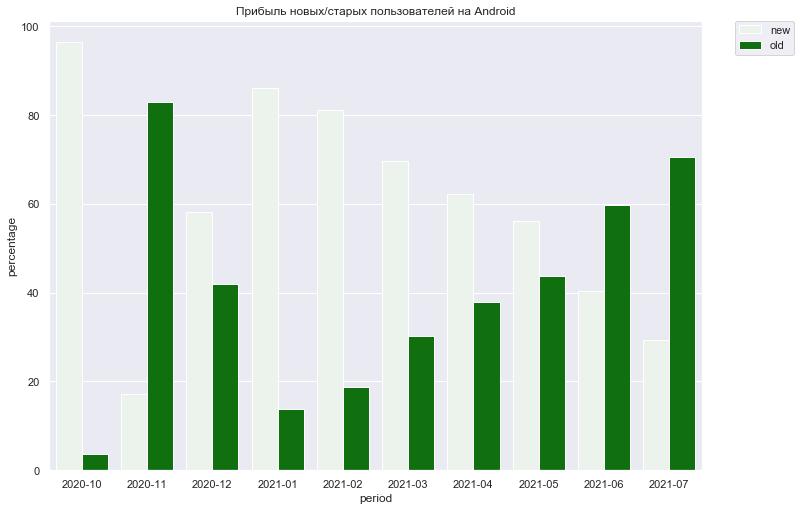

In [78]:
sns.barplot(x="period",  y="percentage", hue='user_category', data=revenues_by_platform.query('platform == "Android"'), color='green')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Прибыль новых/старых пользователей на Android')

Text(0.5, 1.0, 'Прибыль новых/старых пользователей на iOS')

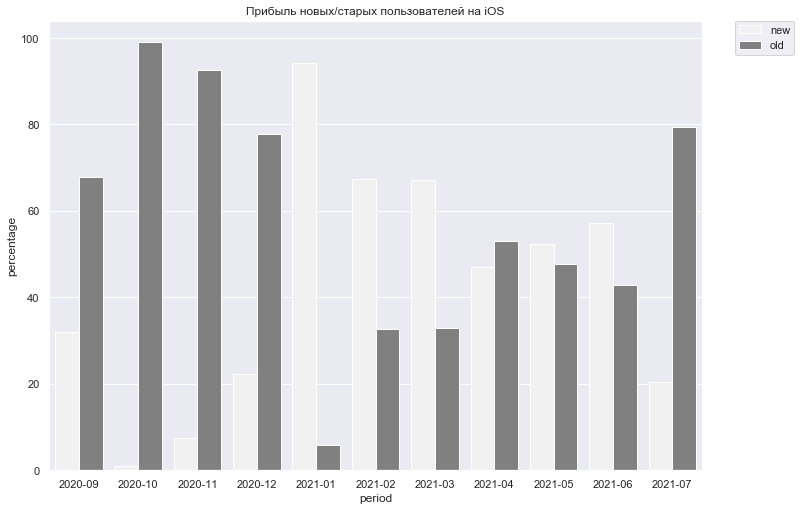

In [79]:
sns.barplot(x="period",  y="percentage", hue='user_category', data=revenues_by_platform.query('platform == "iOS"'), color='gray')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Прибыль новых/старых пользователей на iOS')

Text(0.5, 1.0, 'Прибыль новых/старых пользователей на web-версии')

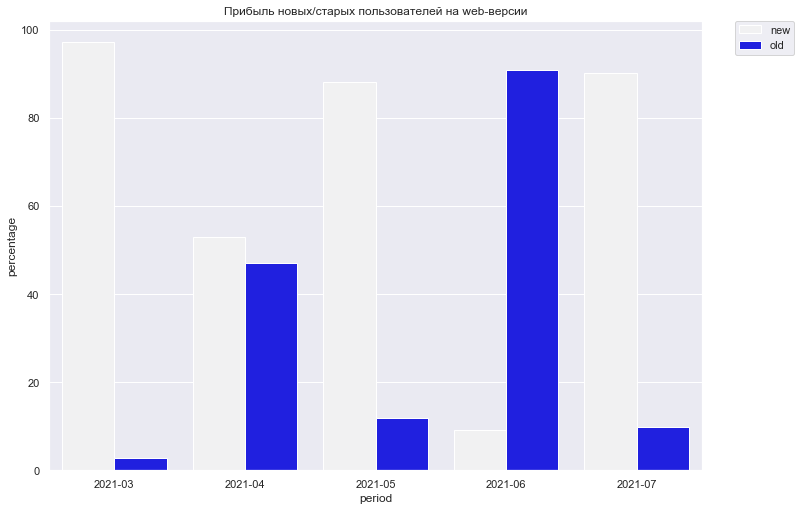

In [80]:
sns.barplot(x="period",  y="percentage", hue='user_category', data=revenues_by_platform.query('platform == "Web"'), color='blue')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Прибыль новых/старых пользователей на web-версии')

In [81]:
revenues_by_version = (
    clients.groupby(['version_name', 'month_period'], as_index=False).Amount.sum().rename(columns={'Amount':'total'})
)

In [82]:
revenues_by_version_category = (
    clients.groupby(['version_name', 'month_period', 'user_category'], as_index=False)
    .Amount.sum().rename(columns={'Amount':'revenue'})
)

In [83]:
revenues_by_version = (
    pd.merge(revenues_by_version_category, revenues_by_version, how='outer', on=['version_name', 'month_period'])
)

In [84]:
revenues_by_version['percentage'] = (revenues_by_version.revenue / revenues_by_version.total * 100).round(2)

In [85]:
revenues_by_version = revenues_by_version.query('percentage != 100')

Text(0.5, 1.0, 'Прибыль новых/старых пользователей по версиям')

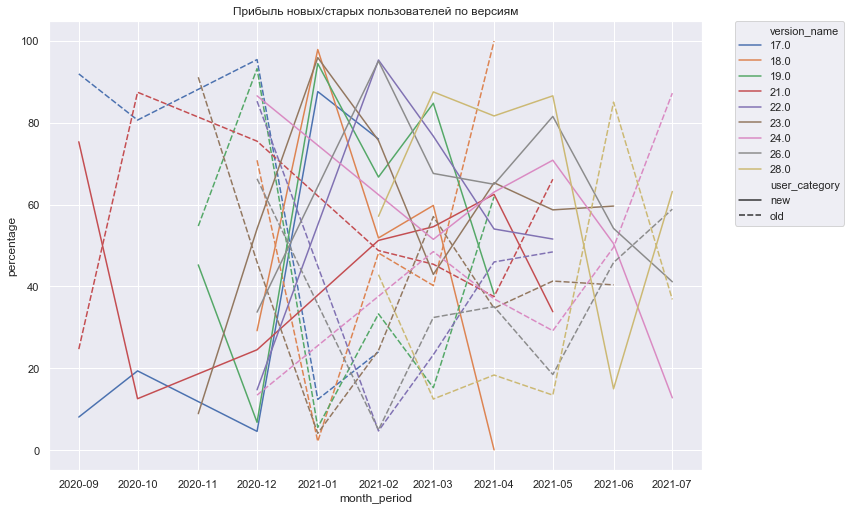

In [86]:
sns.lineplot(data=revenues_by_version, x='month_period', y='percentage', hue='version_name', style='user_category')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Прибыль новых/старых пользователей по версиям')

**Посмотрим на конверсию и ARPU по платформам и версиям:**

In [87]:
total_converstion_platform = (
    conversion_by_platform.groupby('platform', as_index=False).agg({'clients':'sum', 'all_users':'sum'})
)

In [88]:
total_converstion_platform['conversion'] = (
    (total_converstion_platform.clients / total_converstion_platform.all_users * 100).round(2)
)

In [89]:
total_converstion_platform

,platform,clients,all_users,conversion
0,Android,6257,12786478.0,0.05
1,Web,290,177142.0,0.16
2,iOS,12767,9656614.0,0.13


In [90]:
total_converstion_version = (
    conversion_by_ver.groupby('version_name', as_index=False).agg({'clients':'sum', 'all_users':'sum'})
)

In [91]:
total_converstion_version['conversion'] = (
    (total_converstion_version.clients / total_converstion_version.all_users * 100).round(2)
)

In [92]:
total_converstion_version

,version_name,clients,all_users,conversion
0,17.0,1379,709173.0,0.19
1,18.0,1060,1441148.0,0.07
2,19.0,1973,2139827.0,0.09
3,21.0,4426,3667174.0,0.12
4,22.0,1570,5043590.0,0.03
5,23.0,5530,4910316.0,0.11
6,24.0,1989,2416913.0,0.08
7,26.0,461,653439.0,0.07
8,28.0,491,359911.0,0.14


In [93]:
arpu_android = clients.query('platform == "Android"').Amount.mean()
arpu_ios = clients.query('platform == "iOS"').Amount.mean()
arpu_web = clients.query('platform == "Web"').Amount.mean()

In [94]:
print(f'ARPU Android: {arpu_android:.2f}\nARPU iOS: {arpu_ios:.2f}\nARPU Web: {arpu_web:.2f}')

ARPU Android: 160.58
ARPU iOS: 187.39
ARPU Web: 72.36


In [97]:
def compare_groups(df, groups):
    pvalues = []
    vs_groups = []
    group_combinations = list(combinations(groups, 2))
    for group in group_combinations:
        df1 = df.drop_duplicates(subset='user_id').query(group[0]).Amount
        df2 = df.drop_duplicates(subset='user_id').query(group[1]).Amount
        stat, p_value = stats.mannwhitneyu(df1, df2)
        pvalues.append(p_value)
        vs_groups.append(group[0].split("==")[-1] + ' vs. ' + group[1].split("==")[-1])

    group_table = pd.DataFrame()
    group_table['group'] = vs_groups
    group_table['p-value'] = pvalues
    group_table['Bonferroni_correction'] = bonferroni(pvalues, alpha = 0.05)
    return group_table

In [98]:
res = compare_groups(clients, ['platform == "Android"', 'platform == "iOS"', 'platform == "Web"'])

In [99]:
res

,group,p-value,Bonferroni_correction
0,"""Android"" vs. ""iOS""",0.469806,False
1,"""Android"" vs. ""Web""",0.024921,False
2,"""iOS"" vs. ""Web""",0.030007,False


In [100]:
for ver in versions:
    arpu_ver = clients.query('version_name == @ver').Amount.mean()
    print(f'ARPU {ver}: {arpu_ver:.2f}')

ARPU 17.0: 228.57
ARPU 18.0: 256.48
ARPU 19.0: 191.38
ARPU 21.0: 176.06
ARPU 22.0: 184.21
ARPU 23.0: 166.92
ARPU 24.0: 151.50
ARPU 26.0: 98.00
ARPU 28.0: 82.20


In [101]:
ver_queries = ["version_name == " + '\"' + v + '\"' for v in versions]

In [102]:
res = compare_groups(clients, ver_queries)

In [103]:
res

,group,p-value,Bonferroni_correction
0,"""17.0"" vs. ""18.0""",0.285463,False
1,"""17.0"" vs. ""19.0""",0.000504,True
2,"""17.0"" vs. ""21.0""",0.064494,False
3,"""17.0"" vs. ""22.0""",0.003533,False
4,"""17.0"" vs. ""23.0""",0.003378,False
5,"""17.0"" vs. ""24.0""",0.009893,False
6,"""17.0"" vs. ""26.0""",0.458204,False
7,"""17.0"" vs. ""28.0""",0.275634,False
8,"""18.0"" vs. ""19.0""",0.002060,False
9,"""18.0"" vs. ""21.0""",0.197134,False


**Посмотрим на количество ошибок в разных платформах и версиях:**

In [104]:
events.query('event_type == "ERROR" or event_type == "error"').groupby('platform', as_index=False).event_type.count()

,platform,event_type
0,Android,3759506
1,Web,204
2,iOS,1674135


In [105]:
events.query('event_type == "ERROR" or event_type == "error" and version_name in @versions').groupby('version_name', as_index=False).event_type.count()

,version_name,event_type
0,17.0,2195
1,18.0,551603
2,19.0,817026
3,20.0,284
4,20.1,121
5,21.0,1023220
6,22.0,2612705
7,23.0,109777
8,23.1,17
9,24.0,83841


In [106]:
events.query('event_type == "ERROR" or event_type == "error" and version_name in @versions').groupby(['platform', 'version_name'], as_index=False).event_type.count()

,platform,version_name,event_type
0,Android,20.0,256
1,Android,20.1,121
2,Android,21.0,1000716
3,Android,22.0,2607859
4,Android,23.0,57270
5,Android,23.1,17
6,Android,24.0,83841
7,Android,24.1,1369
8,Android,25.0,1
9,Android,26.0,5148
